<a href="https://colab.research.google.com/github/rajdeepmondal1/quora-question-similarity-kaggle/blob/main/Detecting_Duplicate_Quora_Questions_Kaggle_Competetion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing Detecting Similarity between Two Questions using Quora Duplicate Pair dataset.

A live version of the deployed application can be found - https://cobalt-passkey-347903.uc.r.appspot.com/

In [1]:
!pip install kaggle
!rm -rf ~/.kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle competitions download -c quora-question-pairs

 99% 305M/309M [00:13<00:00, 31.7MB/s]
100% 309M/309M [00:13<00:00, 24.6MB/s]


In [3]:
import zipfile

def unzip_data(filename):
  """
  Unzips filename into the current working directory.
  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

In [4]:
unzip_data('/content/quora-question-pairs.zip')

In [5]:
unzip_data('/content/train.csv.zip')

In [6]:
unzip_data('/content/test.csv.zip')

In [7]:
import pandas as pd

quora_train = pd.read_csv('/content/train.csv')
quora_train = quora_train.drop(['id', 'qid1', 'qid2'], axis=1)
quora_train.head()

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [8]:
quora_test = pd.read_csv('/content/test.csv')
quora_test.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [9]:
quora_train[quora_train['is_duplicate'] == 1][['question1', 'question2']].head()

,question1,question2
5,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan..."
7,How can I be a good geologist?,What should I do to be a great geologist?
11,How do I read and find my YouTube comments?,How can I see all my Youtube comments?
12,What can make Physics easy to learn?,How can you make physics easy to learn?
13,What was your first sexual experience like?,What was your first sexual experience?


In [10]:
quora_train[quora_train['is_duplicate'] == 0][['question1', 'question2']].head()

,question1,question2
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?


In [11]:
from scipy.spatial.distance import cosine, jaccard, canberra, euclidean
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords
from nltk import word_tokenize
from google.colab import drive
import xgboost as xgb
import numpy as np
import zipfile
import gensim
import nltk
import copy

In [12]:
def create_feature_set__1(quora_train):
  """
    Creating feature set 1 for the input
    args: quora_train: list of question pairs
  """
  # length based features
  quora_train['length_q1'] = quora_train['question1'].apply(
      lambda x: len(str(x)))
  quora_train['length_q2'] = quora_train['question2'].apply(
      lambda x: len(str(x)))

  # difference in lengths of two questions
  quora_train['difference_in_length'] = quora_train['length_q1'] - quora_train['length_q2']

  # common words in the two questions
  quora_train['common_words'] = quora_train.apply(
      lambda x: len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2'])
                                                            .lower()
                                                            .split()))), axis=1)
  print('Created Feature Set 1 - \'length_q1\', \'length_q2\', \'difference_in_length\', \'common_words\'')

In [13]:
# Creating feature set 1
create_feature_set__1(quora_train)

Created Feature Set 1 - 'length_q1', 'length_q2', 'difference_in_length', 'common_words'


In [14]:
# Initializing the TF-IDF vectorizer for question 1
tfidf_vectorized__q1 = TfidfVectorizer(min_df=3,
                                       max_features=None,
                                       strip_accents='unicode',
                                       analyzer='word',
                                       token_pattern=r'\w{1,}',
                                       ngram_range=(1, 2),
                                       use_idf=1,
                                       smooth_idf=1,
                                       sublinear_tf=1,
                                       stop_words='english')

# Initializing the TF-IDF vectorizer for question 2
tfidf_vectorized__q2 = TfidfVectorizer(min_df=3,
                                       max_features=None,
                                       strip_accents='unicode',
                                       analyzer='word',
                                       token_pattern=r'\w{1,}',
                                       ngram_range=(1, 2),
                                       use_idf=1,
                                       smooth_idf=1,
                                       sublinear_tf=1,
                                       stop_words='english')

In [15]:
# Fit the TFIDF Vectorizer to our question 1
q1_tfidf_transformed = tfidf_vectorized__q1.fit_transform(quora_train['question1'].fillna(""))

# Fit the TFIDF Vectorizer to our question 2
q2_tfidf_transformed = tfidf_vectorized__q2.fit_transform(quora_train['question2'].fillna(""))

In [16]:
# Using SVD to select 180 most important compnents
svd_q1 = TruncatedSVD(n_components=180)
svd_q2 = TruncatedSVD(n_components=180)

In [17]:
question1_vectors = svd_q1.fit_transform(q1_tfidf_transformed)
question2_vectors = svd_q2.fit_transform(q2_tfidf_transformed)

In [18]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [19]:
!cp '/content/gdrive/MyDrive/GoogleNews-vectors-negative300.bin.gz' '/content/GoogleNews-vectors-negative300.bin.gz'

In [20]:
model = gensim.models.KeyedVectors.load_word2vec_format('/content/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [21]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [22]:
stop_words = set(stopwords.words('english'))

In [23]:
print(stop_words)

{'ours', "shouldn't", 'needn', 'against', "you've", "wouldn't", 'to', 'on', 'more', 'wouldn', 'won', 'but', 'who', 'o', 'that', 'do', 'when', 's', 'y', 'yourselves', 'and', "didn't", 'now', 'hadn', "haven't", "hadn't", 'his', 'once', 'then', 'after', 'mightn', 'here', 'hers', 'has', 'couldn', "couldn't", 'down', 'being', 'this', 'there', 'other', 'm', 'any', 'no', 'shouldn', "you're", 'a', 'its', 'so', "mightn't", 'out', 'am', 'whom', 'i', 'at', 'below', 'only', 'him', 'yourself', 'with', 'it', 'ma', "mustn't", "won't", 'of', 'too', "you'll", 'our', 'under', 'both', 'ourselves', 'doing', "doesn't", 'what', 'them', 'the', 'which', 'hasn', 'been', 'don', 'most', 'off', 'over', 'as', 'where', "she's", 'does', 'me', "hasn't", 'isn', 'd', 'their', "weren't", 'for', 'during', 'nor', 'haven', 'very', 'shan', 'll', 'few', 'will', 'myself', 'again', 'each', 'doesn', 'mustn', 'they', "don't", "needn't", "shan't", 'such', 'themselves', 'into', 'some', 'you', 't', 'did', 'yours', 'was', "should've

In [24]:
def sentence2vectors(sentence, model):  
    M = []
    words = word_tokenize(str(sentence).lower())
    for word in words:
        #It shouldn't be a stopword
        if word not in stop_words:
            #nor contain numbers
            if word.isalpha():
                #and be part of word2vec
                if word in model:
                    M.append(model[word])
    M = np.array(M)
    if len(M) > 0:
        v = M.sum(axis=0)
        return v / np.sqrt((v ** 2).sum())
    else:
        return np.zeros(300)

In [25]:
def create_feature_set__2(quora_train):
  """
    Creating feature set 2 for the input
    args: quora_train: list of question pairs
  """
  # creating word2vectors for question 1 and 2
  word2vectors__q1 = np.array([sentence2vectors(question, model) for question in quora_train['question1']])
  word2vectors__q2 = np.array([sentence2vectors(question, model) for question in quora_train['question2']])

  #calculating cosine_distance, jaccard_distance, canberra_distance, euclidean_distance and word_mover_distance
  quora_train['cosine_distance'] = [cosine(x,y) for (x,y) in zip(word2vectors__q1, word2vectors__q2)]
  quora_train['jaccard_distance'] = [jaccard(x,y) for (x,y) in zip(word2vectors__q1, word2vectors__q2)]
  quora_train['canberra_distance'] = [canberra(x,y) for (x,y) in zip(word2vectors__q1, word2vectors__q2)]
  quora_train['euclidean_distance'] = [euclidean(x,y) for (x,y) in zip(word2vectors__q1, word2vectors__q2)]
  print('Created Feature Set 2 - \'cosine_distance\', \'jaccard_distance\', \'canberra_distance\', \'euclidean_distance\'') 

Ccosine Similarity is a measure of similarity between two sequences of numbers. For defining it, the sequences are viewed as vectors in an inner product space, and the cosine similarity is defined as the cosine of the angle between them, that is, the dot product of the vectors divided by the product of their lengths. It follows that the cosine similarity does not depend on the magnitudes of the vectors, but only on their angle. The cosine similarity always belongs to the interval [-1, 1].

Jaccard similarity coefficient, is a statistic used for gauging the similarity and diversity of sample sets. The Jaccard coefficient measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets:

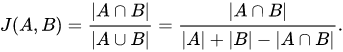

The Canberra distance is a numerical measure of the distance between pairs of points in a vector space. It is a weighted version of L₁ (Manhattan) distance. The Canberra distance d between vectors p and q in an n-dimensional real vector space is given as follows:

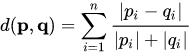
where

image.png
are vectors.

Euclidean distance between two points in Euclidean space is the length of a line segment between the two points. In general, for points given by Cartesian coordinates in n-dimensional Euclidean space, the distance is
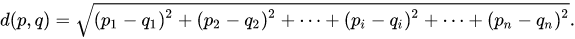

In [26]:
# Creating feature set 2
create_feature_set__2(quora_train)

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Created Feature Set 2 - 'cosine_distance', 'jaccard_distance', 'canberra_distance', 'euclidean_distance'


In [27]:
feature_set__1 = [
                  'length_q1', 
                  'length_q2', 
                  'difference_in_length', 
                  'common_words'
                  ]

In [28]:
feature_set__2 = [
                  'cosine_distance', 
                  'jaccard_distance', 
                  'canberra_distance', 
                  'euclidean_distance', 
                  ]

In [29]:
# obtain features by stacking the question1_vectors and question2_vectors together
feature_set__3 = np.hstack((question1_vectors, question2_vectors))

In [30]:
scaler = StandardScaler()

In [31]:
X = quora_train[feature_set__1 + feature_set__2]
# replace infinity values with NaN, then fill it with 0
X = X.replace([np.inf, -np.inf], np.nan).fillna(0).values
X = scaler.fit_transform(X)
# add the feature set 3 of stacked question 1 and 2 vectors
X = np.hstack((X, feature_set__3))

In [32]:
# take the labels as 'is_duplicate' from quora_train
y = quora_train['is_duplicate'].values.astype('float32').reshape(-1, 1)

In [33]:
np.random.seed(42)
n_rows, n_columns = y.shape

In [34]:
index = np.arange(n_rows)
np.random.shuffle(index)
n_split = n_rows // 10
index_train = index[n_split:]
index_val = index[:n_split]

In [35]:
x_train = X[index_train]
# without using np.ravel the regression goes haywire.
y_train = np.ravel(y[index_train])

In [36]:
x_val = X[index_val]
# without using np.ravel the regression goes haywire.
y_val = np.ravel(y[index_val])

In [37]:
LogisticRegression = LogisticRegression(C=0.1, # Inverse of regularization strength; 
                                        # must be a positive float. Like in support vector machines, 
                                        # smaller values specify stronger regularization.
                                        solver='sag', 
                                        max_iter=1000) # Maximum number of iterations taken for the sag solver to converge.
LogisticRegression.fit(x_train, y_train)

LogisticRegression(C=0.1, max_iter=1000, solver='sag')

In [38]:
prediction = LogisticRegression.predict(x_val)
accuracy = np.sum(prediction == y_val) / len(y_val)
print(f"Logistic Regression accuracy is {round(accuracy, 4) * 100}%")

Logistic Regression accuracy is 74.02%


In [39]:
param_set = {
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'error'],
    'eta': 0.01,
    'max_depth': 4
}

In [40]:
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_val, label=y_val)

In [41]:
XGBRegressor = xgb.train(params=param_set,
                         dtrain=d_train,
                         num_boost_round=2000,
                         evals=[(d_train, 'train'), (d_valid, 'valid')],
                         early_stopping_rounds=20,
                         verbose_eval=50)

[0]	train-logloss:0.690477	train-error:0.302693	valid-logloss:0.690489	valid-error:0.306191
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 20 rounds.
[50]	train-logloss:0.601455	train-error:0.288058	valid-logloss:0.602033	valid-error:0.290336
[100]	train-logloss:0.556656	train-error:0.279884	valid-logloss:0.557848	valid-error:0.281827
[150]	train-logloss:0.531042	train-error:0.276845	valid-logloss:0.532733	valid-error:0.279329
[200]	train-logloss:0.514365	train-error:0.272425	valid-logloss:0.516412	valid-error:0.27463
[250]	train-logloss:0.502694	train-error:0.26714	valid-logloss:0.505007	valid-error:0.269559
[300]	train-logloss:0.493939	train-error:0.263722	valid-logloss:0.496495	valid-error:0.266294
[350]	train-logloss:0.487066	train-error:0.260385	valid-logloss:0.489818	valid-error:0.263474
[400]	train-logloss:0.481301	train-error:0.257381	valid-logloss:0.484258	valid-error:0.260283
[450]	train-

In [42]:
xgb_prediction = (XGBRegressor.predict(d_valid) >= 0.5).astype(int)
xgb_accuracy = np.sum(xgb_prediction == y_val) / len(y_val)
print(f"XGBoost Regression accuracy is {round(xgb_accuracy, 4) * 100}%")

XGBoost Regression accuracy is 76.05%


In [54]:
from tqdm.notebook import tqdm
import tensorflow as tf
import numpy as np
print("TensorFlow version %s" % tf.__version__)

TensorFlow version 2.8.0


In [60]:
try:
    df = quora_train[['question1', 'question2', 'is_duplicate']]
except:
    df = pd.read_csv('/content/train.csv')
    df = df.drop(['id', 'qid1', 'qid2'], axis=1)
    
df = df.fillna('')
y = df['is_duplicate'].values

In [61]:
# Setting the parameters
max_len = 40
max_features = 200000
kernel_size = 5
num_filters = 64

In [62]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=200000)
tokenizer.fit_on_texts(list(df['question1'].values) + list(df['question2'].values.astype(str)))

In [63]:
x1 = tokenizer.texts_to_sequences(df.question1.values)
x1 = tf.keras.preprocessing.sequence.pad_sequences(x1, maxlen=max_len)

In [64]:
x2 = tokenizer.texts_to_sequences(df.question2.values.astype(str))
x2 = tf.keras.preprocessing.sequence.pad_sequences(x2, maxlen=max_len)

In [65]:
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip

--2022-04-29 10:33:43--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2022-04-29 10:33:43--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2022-04-29 10:33:44--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip

In [66]:
word_index = tokenizer.word_index

In [67]:
embedding_matrix = np.zeros((len(word_index) + 1, 300), dtype='float32')
 
glove_zip = zipfile.ZipFile('/content/glove.840B.300d.zip')
glove_file = glove_zip.filelist[0]
 
f_in = glove_zip.open(glove_file)
for line in tqdm(f_in):
    values = line.split(b' ')
    word = values[0].decode()
    if word not in word_index:
        continue
    i = word_index[word]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_matrix[i, :] = coefs
 
f_in.close()
glove_zip.close()

0it [00:00, ?it/s]

In [68]:
# # 1. question_1_model_1
question_1_model_1_inputs = tf.keras.Input(dtype=tf.int32, shape=(max_len))
glove_embeddings = tf.keras.layers.Embedding(len(word_index) + 1,
                                             300,
                                             weights=[embedding_matrix],
                                             input_length=40,
                                             trainable=False)(question_1_model_1_inputs)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(300,
                                                          activation='relu'))(glove_embeddings)
output_layer = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1),
                                      output_shape=(300,))(x)
question_1_model_1 = tf.keras.Model(inputs=question_1_model_1_inputs,
                                    outputs=output_layer)

# # 2. question_2_model_1
question_2_model_1_inputs = tf.keras.Input(dtype=tf.int32, shape=(max_len))
glove_embeddings = tf.keras.layers.Embedding(len(word_index) + 1,
                                             300,
                                             weights=[embedding_matrix],
                                             input_length=40,
                                             trainable=False)(question_2_model_1_inputs)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(300,
                                                          activation='relu'))(glove_embeddings)
output_layer = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1),
                                      output_shape=(300,))(x)
question_2_model_1 = tf.keras.Model(inputs=question_2_model_1_inputs,
                                    outputs=output_layer)

# # 3. question_1_model_2
question_1_model_2_inputs = tf.keras.Input(dtype=tf.int32, shape=(max_len))
glove_embeddings = tf.keras.layers.Embedding(len(word_index) + 1,
                                             300,
                                             weights=[embedding_matrix],
                                             input_length=40,
                                             trainable=False)(question_1_model_2_inputs)
x = tf.keras.layers.Convolution1D(filters=num_filters,
                                  kernel_size=kernel_size,
                                  padding='valid',
                                  activation='relu')(glove_embeddings)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Convolution1D(filters=num_filters,
                                  kernel_size=kernel_size,
                                  padding='valid',
                                  activation='relu')(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(300)(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.BatchNormalization()(x)
question_1_model_2 = tf.keras.Model(inputs=question_1_model_2_inputs,
                                    outputs=output_layer)

# # 4. question_2_model_2
question_2_model_2_inputs = tf.keras.Input(dtype=tf.int32, shape=(max_len))
glove_embeddings = tf.keras.layers.Embedding(len(word_index) + 1,
                                             300,
                                             weights=[embedding_matrix],
                                             input_length=40,
                                             trainable=False)(question_2_model_2_inputs)
x = tf.keras.layers.Convolution1D(filters=num_filters,
                                  kernel_size=kernel_size,
                                  padding='valid',
                                  activation='relu')(glove_embeddings)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Convolution1D(filters=num_filters,
                                  kernel_size=kernel_size,
                                  padding='valid',
                                  activation='relu')(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(300)(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.BatchNormalization()(x)
question_2_model_2 = tf.keras.Model(inputs=question_2_model_2_inputs,
                                    outputs=output_layer)

# # 5. question_1_model_3
question_1_model_3_inputs = tf.keras.Input(dtype=tf.int32, shape=(max_len))
embeddings = tf.keras.layers.Embedding(len(word_index) + 1, 
                                       300, 
                                       input_length=40)(question_1_model_3_inputs)
x = tf.keras.layers.Dropout(0.2)(embeddings)
x = tf.keras.layers.LSTM(300, recurrent_dropout=0.2)(x)
output_layer = tf.keras.layers.Dropout(0.2)(x)
question_1_model_3 = tf.keras.Model(inputs=question_1_model_3_inputs,
                                    outputs=output_layer)

# # 6. question_2_model_3
question_2_model_3_inputs = tf.keras.Input(dtype=tf.int32, shape=(max_len))
embeddings = tf.keras.layers.Embedding(len(word_index) + 1, 
                                       300, 
                                       input_length=40)(question_2_model_3_inputs)
x = tf.keras.layers.Dropout(0.2)(embeddings)
x = tf.keras.layers.LSTM(300, recurrent_dropout=0.2)(x)
output_layer = tf.keras.layers.Dropout(0.2)(x)
question_2_model_3 = tf.keras.Model(inputs=question_2_model_3_inputs,
                                    outputs=output_layer)

# Merged Model
merged_model = tf.keras.layers.Concatenate()([question_1_model_1.output, question_2_model_1.output, 
                                              question_1_model_2.output, question_2_model_2.output,
                                              question_1_model_3.output, question_2_model_3.output])

x = tf.keras.layers.BatchNormalization()(merged_model)

for _ in range(5):
  x = tf.keras.layers.Dense(300)(x)
  x = tf.keras.layers.PReLU()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.BatchNormalization()(x)

final_output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

final_model = tf.keras.Model(inputs=[question_1_model_1.input, question_2_model_1.input,
                                     question_1_model_2.input, question_2_model_2.input,
                                     question_1_model_3.input, question_2_model_3.input],
                             outputs=final_output)

This Model was inspired by - 
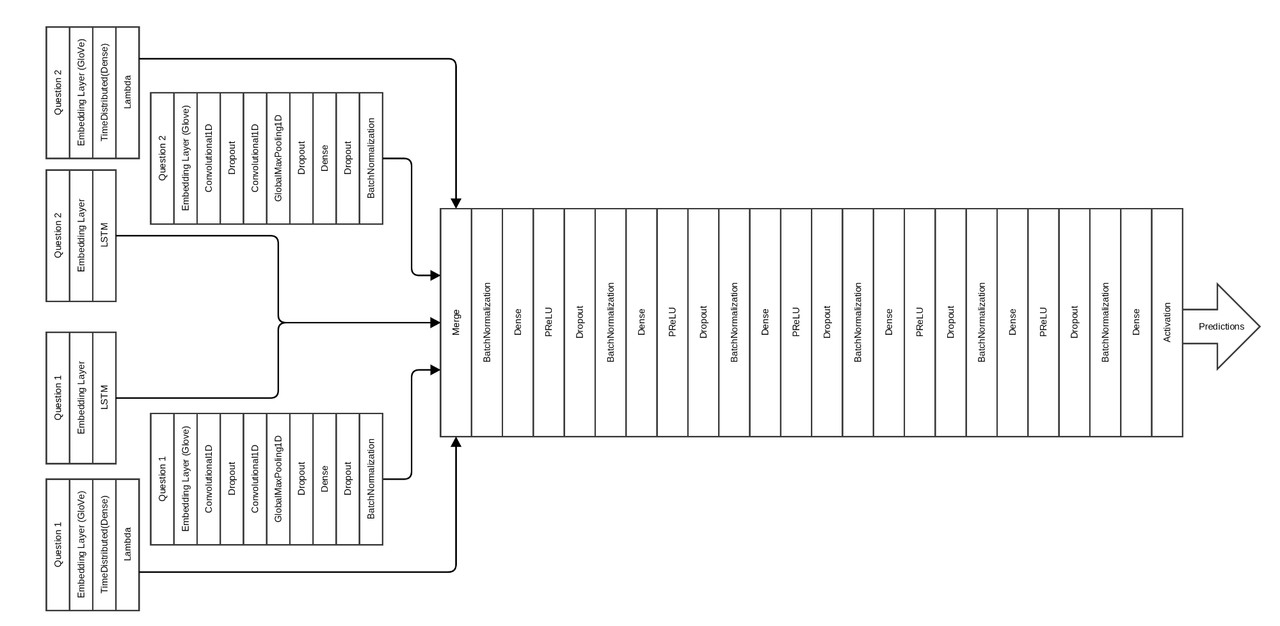

When I was tackling this problem I saw this in my search from Abhishek Thakur, who is a personal hero of mine in this space and though it would be interesting if I could implement this challenging model myself using Keras Functional API.

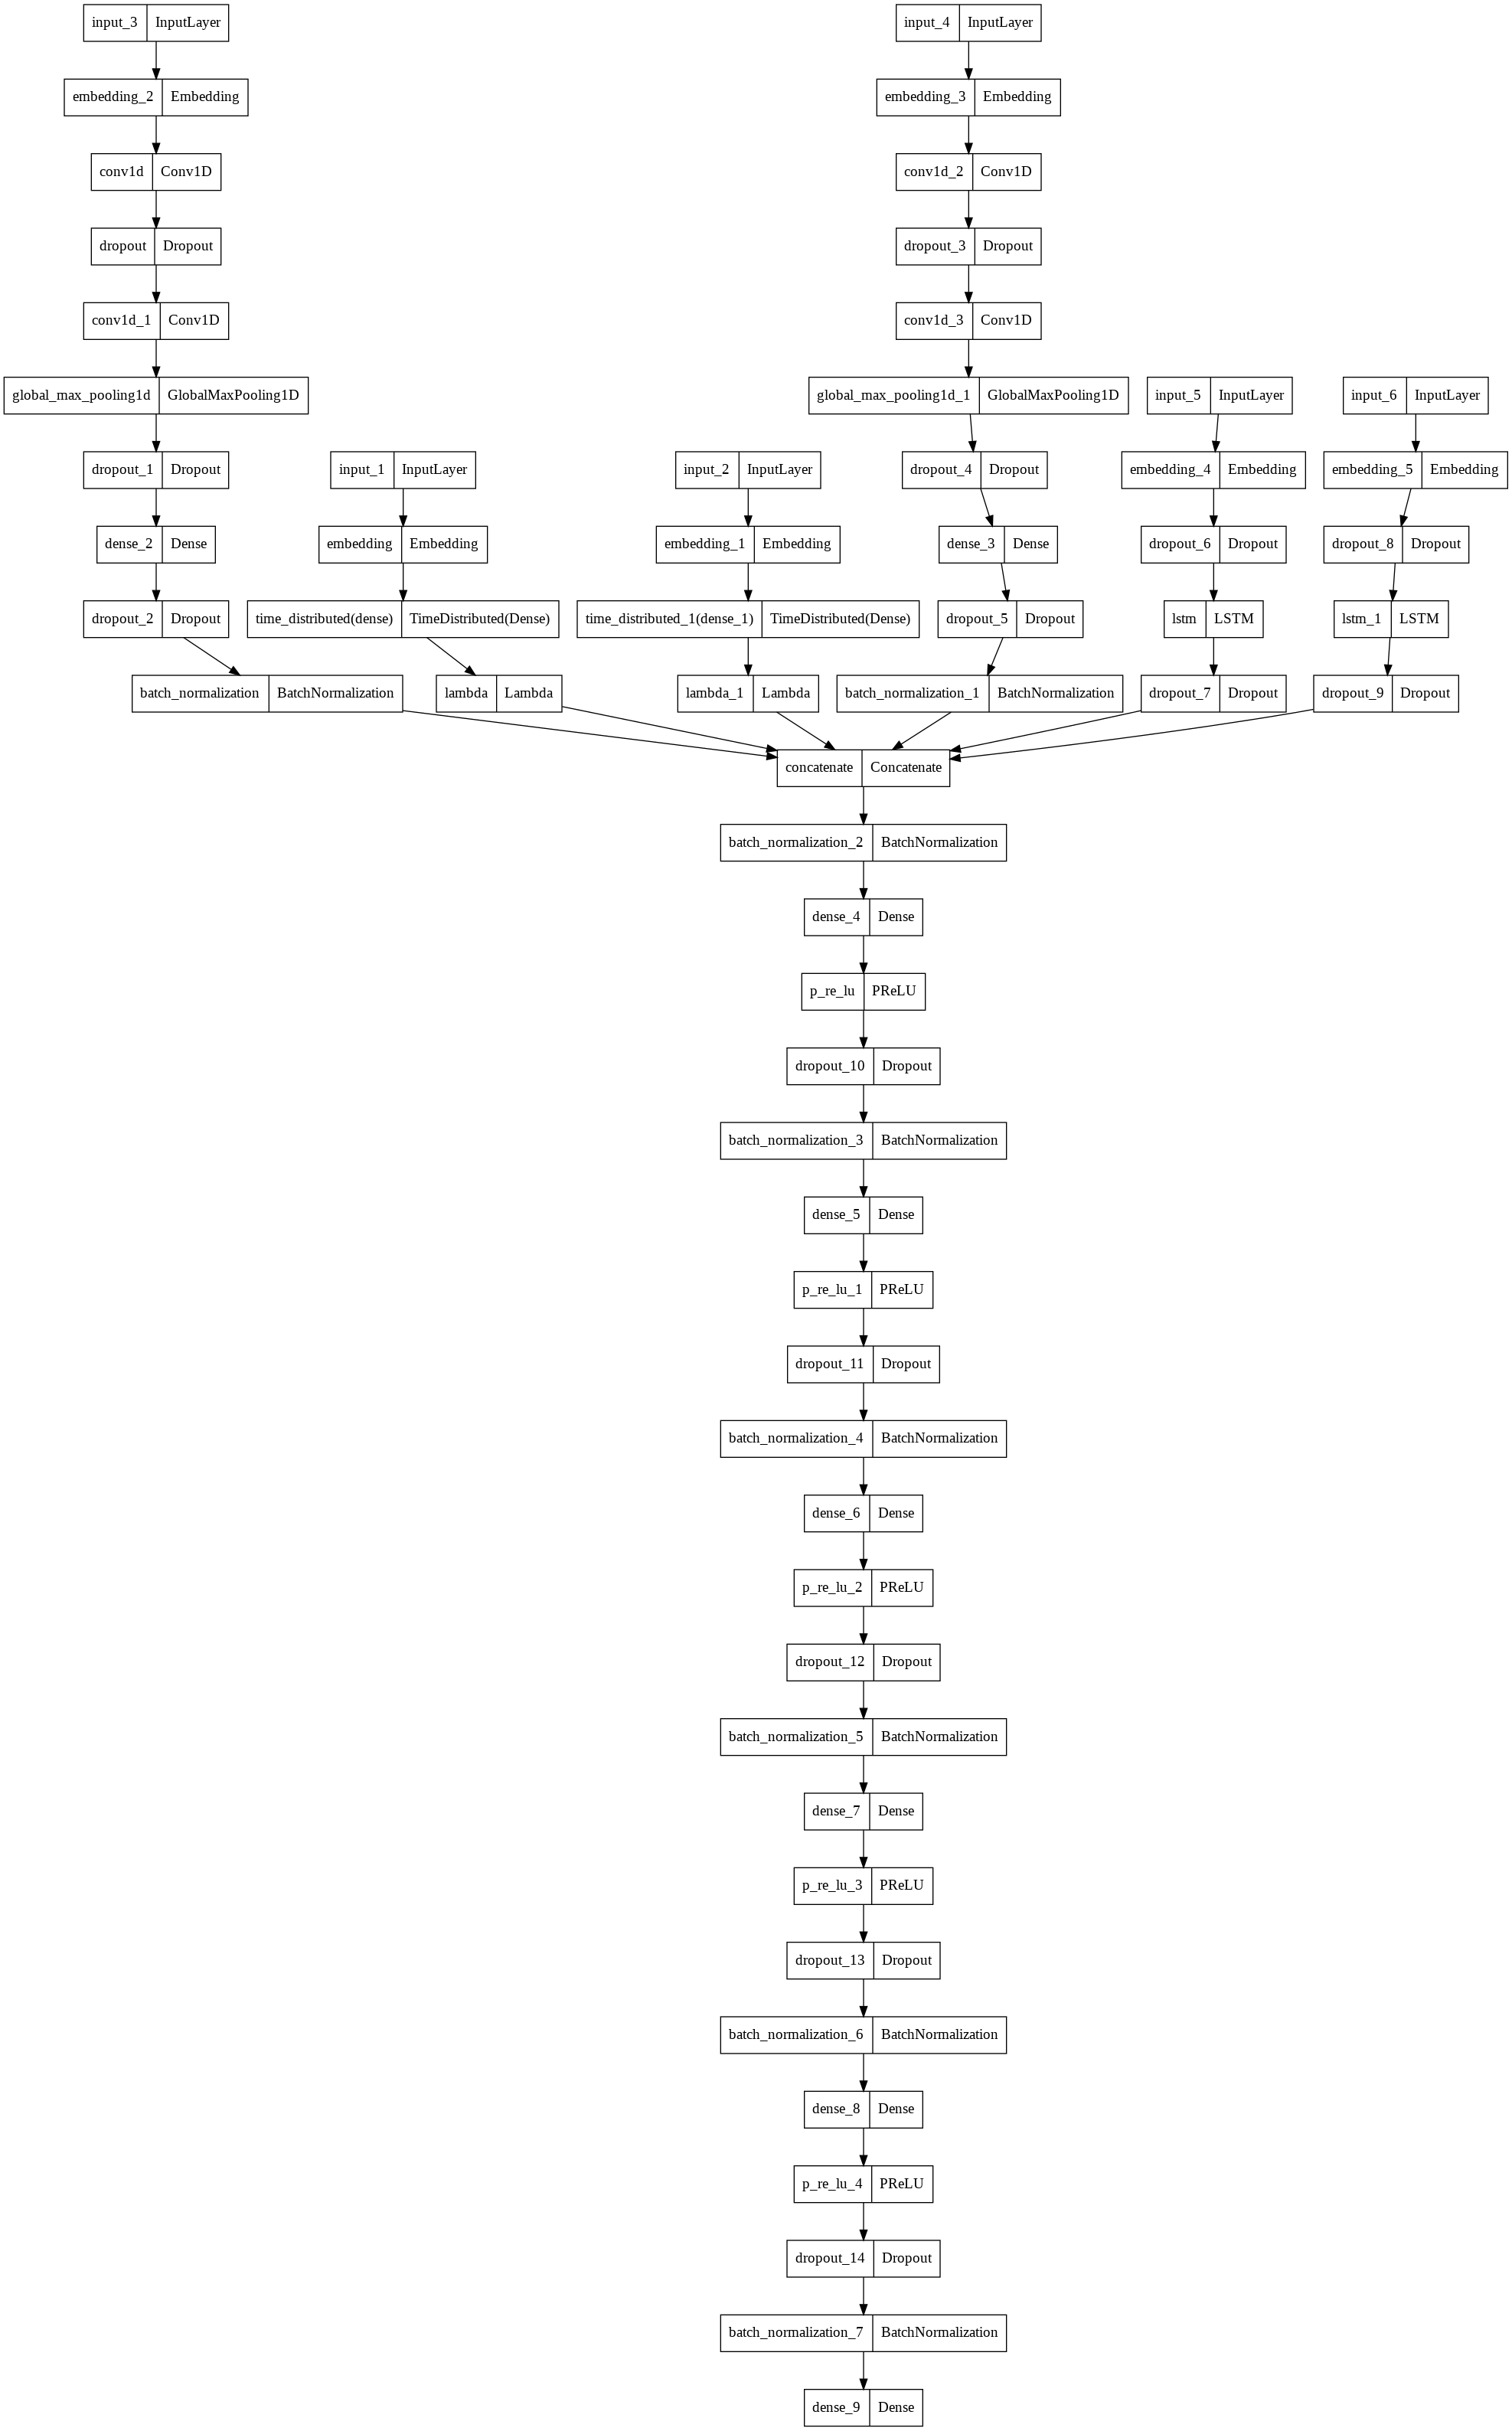

In [69]:
tf.keras.utils.plot_model(final_model)

In [70]:
final_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['accuracy'])

In [71]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('weights.h5', 
                                                      monitor='val_accuracy', 
                                                      save_best_only=True, 
                                                      verbose=2)

In [72]:
model_inputs = [x1, x2, x1, x2, x1, x2]

In [ ]:
final_model_history = final_model.fit(model_inputs, 
                                      y=y, 
                                      batch_size=384, 
                                      epochs=15,
                                      verbose=1, 
                                      validation_split=0.1, 
                                      shuffle=True, 
                                      callbacks=[model_checkpoint])

Epoch 1/15
948/948 [==============================] - ETA: 0s - loss: 0.5131 - accuracy: 0.7426
Epoch 1: val_accuracy improved from -inf to 0.79114, saving model to weights.h5
948/948 [==============================] - 304s 301ms/step - loss: 0.5131 - accuracy: 0.7426 - val_loss: 0.4374 - val_accuracy: 0.7911
Epoch 2/15
948/948 [==============================] - ETA: 0s - loss: 0.4015 - accuracy: 0.8115
Epoch 2: val_accuracy improved from 0.79114 to 0.79982, saving model to weights.h5
948/948 [==============================] - 278s 293ms/step - loss: 0.4015 - accuracy: 0.8115 - val_loss: 0.4189 - val_accuracy: 0.7998
Epoch 3/15
948/948 [==============================] - ETA: 0s - loss: 0.3260 - accuracy: 0.8519
Epoch 3: val_accuracy improved from 0.79982 to 0.80012, saving model to weights.h5
948/948 [==============================] - 278s 293ms/step - loss: 0.3260 - accuracy: 0.8519 - val_loss: 0.4269 - val_accuracy: 0.8001
Epoch 4/15
948/948 [==============================] - ETA: 0s

In [ ]:
final_model.save('/content/gdrive/MyDrive/machine_learning_models/practice/quora_question_similarity')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/machine_learning_models/practice/quora_question_similarity/assets


In [55]:
new_model = tf.keras.models.load_model('/content/gdrive/MyDrive/machine_learning_models/practice/quora_question_similarity')

In [73]:
results = new_model.evaluate(model_inputs, y, batch_size=384)

1053/1053 [==============================] - 58s 46ms/step - loss: 0.1198 - accuracy: 0.9695


In [74]:
def convert_text(text, tokenizer, pad_sequences):
    x = tokenizer.texts_to_sequences(text)
    x = pad_sequences(x, maxlen=max_len)
    return x

In [75]:
def predict_similarity(question_1, question_2, model):
  question_1 = convert_text([question_1], tokenizer, tf.keras.preprocessing.sequence.pad_sequences)
  question_2 = convert_text([question_2], tokenizer, tf.keras.preprocessing.sequence.pad_sequences)
  prediction = model.predict([question_1, question_2, 
                              question_1, question_2, 
                              question_1, question_2])
  return round(prediction[0][0] * 100, 3) 

In [76]:
question_1 = "Can nuclear fusion power cause global warming?"
question_2 = "Is nuclear fusion power the reason for global warming?"

In [77]:
prediction = predict_similarity(question_1, question_2, new_model)
print(f'Similarity between \n \'{question_1}\' and \n \'{question_2}\' \n is {prediction}%')

Similarity between 
 'Can nuclear fusion power cause global warming?' and 
 'Is nuclear fusion power the reason for global warming?' 
 is 99.999%


In [78]:
question_1 = "Is Jeff Bezos the founder of Amazon?"
question_2 = "Is Amazon the best customer centric company in the world?"

In [79]:
prediction = predict_similarity(question_1, question_2, new_model)
print(f'Similarity between \n \'{question_1}\' and \n \'{question_2}\' \n is {prediction}%')

Similarity between 
 'Is Jeff Bezos the founder of Amazon?' and 
 'Is Amazon the best customer centric company in the world?' 
 is 0.047%
